# Sets iniciais do projeto.
Instalação de bibliotecas necessárias, imports e criação dos datasets de teste

In [7]:
# Instalação das bibliotecas

# %pip install sslbookdata
# %pip install scikit-learn
# %pip install matplotlib
# %pip install pandas
# %pip install hdbscan
# %pip install networkx
# %pip install pygsp

In [8]:
# Importação das bibliotecas

from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import sslbookdata
import pygsp

In [36]:
# Upload dos datasets

datasets = {
    'USPS': sslbookdata.load_usps(0, return_X_y=True),
    'COIL': sslbookdata.load_coil2(0),
    'DIGIT': sslbookdata.load_digit1(0),
    'GC': sslbookdata.load_g241c(0),
    'GN': sslbookdata.load_g241n(0),
    # 'TEXT': sslbookdata.load_text(0)
}

# Quais serão os passos da construção desse trabalho?
1) Geração de um grafo a partir do dataset
2) Difusão dos rótulos a partir do grafo
3) Gerar uma análise dos resultados obtidos


# 1) Geração de um grafo a partir do dataset

O conceito abordado é a utilização dos dois primeiros passos do HDBSCAN* a fim de gerar uma árvore geradora mínima, esse é nosso objetivo

## Primeira etapa do HDBSCAN* - Computar core distance para todas instâncias do dataset em relação a um número mínimo de pontos

Conceito de Core Distance: Raio mínimo necessário para que uma instância qualquer X seja considerado um objeto core, tendo em vista um número mínimo de pontos próximos (incluindo o próprio ponto)

In [ ]:
# Codigo que computa o core distance e retorna um array que contem os raios minimos 
# e as 3 instâncias que são as mais próximas de determinado ponto

def computeCoreDistance(datasetToComputeDistance, min_samples):
    datasetToComputeDistance = datasetToComputeDistance['data']
    list_de_raios_minimos = []
    list_de_indices_vizinhos = []
    neighbors = NearestNeighbors(n_neighbors=min_samples).fit(datasetToComputeDistance)

    distances, indices = neighbors.kneighbors(datasetToComputeDistance)
    for i in range(len(datasetToComputeDistance)):
        list_de_raios_minimos.append(distances[i, -1])
        list_de_indices_vizinhos.append(indices[i])
    return list_de_raios_minimos, list_de_indices_vizinhos

In [ ]:
# Print dos raios minimos, das 3 instancias mais proximas de cada ponto 
# e o dataset em 2d com os 3 pontos mais próximos da primeira instâncias

def plotGraphAndStats(dataset_name, dataset, listOfNeighboringIndices, listOfMinimumRadius):
    datasetForPlot = dataset['data']
    plt.figure()
    for i in range(1, len(datasetForPlot)):
        plt.scatter(datasetForPlot[i, 0], datasetForPlot[i, 1], c='b', marker='o', s=8)
    for i in listOfNeighboringIndices[0]:
        plt.scatter(datasetForPlot[i, 0], datasetForPlot[i, 1], c='r', marker='o', s=8)
    plt.scatter(datasetForPlot[0, 0], datasetForPlot[0, 1], c='r', marker='x', s=32, label='Instância 1')
    print(f'Raio mínimo para instância 1 ser um core: {listOfMinimumRadius[0]}')
    print(f'Lista das intâncias mais perto da instância 1: {listOfNeighboringIndices[0]}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Instâncias do dataset {dataset_name}')
    plt.show()

Raio mínimo para instância 1 ser um core: 3.5340244364500677
Lista das intâncias mais perto da instância 1: [   0 1107  695]


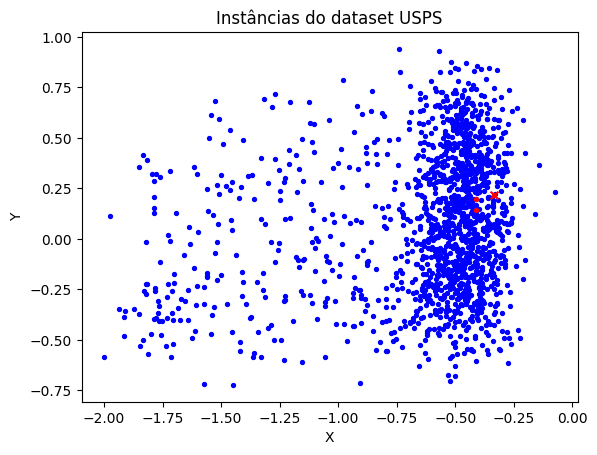

In [ ]:
datasetTreino = datasets['USPS']
numeroMinimoDePontos = 3
listaDeRaiosMinimos, listaDeIndicesVizinhos = computeCoreDistance(datasetTreino, numeroMinimoDePontos)
plotGraphAndStats('USPS', datasetTreino, listaDeIndicesVizinhos, listaDeRaiosMinimos)

## Segunda etapa do HDBSCAN* - Gerar uma árvore geradora mínima a partir do grafo de alcançabilidade mútua

Grafo de alcançabilidade mútua: grafo completo em que os pontos são os objetos do dataset e os pesos das areastas é a distância de alcançabilidade entre os pontos, dado os pontos x1 e x2 essa ditância é calculada pelo maior valor entre: CoreDistance(X1), CoreDistance(X2) e Distância(X1, X2)

In [ ]:
# TEMOS QUE CRIAR UMA FUNÇÃO QUE CALCULA A DISTÂNCIA DE ALCANÇABILIDADE ENTRE DOIS PONTOS

def mutualReachabilityDistanceCalculation(datasetParaAlcancabilidade, printarDistancias=False):
    datasetParaAlcancabilidade = datasetParaAlcancabilidade['data']
    distancia_alcancabilidade_mutua = []
    for i in range(len(datasetParaAlcancabilidade)):
        alcancabilidade_mutua = []
        for j in range(len(datasetParaAlcancabilidade)):
            if i != j:
                distancia = np.linalg.norm(datasetParaAlcancabilidade[i] - datasetParaAlcancabilidade[j])
                reachability_distance = max(distancia, listaDeRaiosMinimos[j])
                alcancabilidade_mutua.append(reachability_distance)
        distancia_alcancabilidade_mutua.append(alcancabilidade_mutua)

    if printarDistancias:
        print("Distância de Alcançabilidade Mútua:")
        for i in range(len(distancia_alcancabilidade_mutua)):
            for j in range(len(distancia_alcancabilidade_mutua[i])):
                print(f"Ponto {i} para Ponto {j}: {distancia_alcancabilidade_mutua[i][j]}")
                
    return distancia_alcancabilidade_mutua

In [ ]:
# Criação de um grafo de alcançabilidade mutua

def createReachabilityGraph(mutual_reachability_distance):
    G = nx.Graph()
    num_instancias = len(mutual_reachability_distance)
    G.add_nodes_from(range(num_instancias))
    for i in range(len(mutual_reachability_distance)):
        for j in range(len(mutual_reachability_distance[i])):
            peso = mutual_reachability_distance[i][j]
            G.add_edge(i, j, weight=peso)
    return G


In [ ]:
# Criação de uma árvore geradora minima a partir de um grafo

def createMinimumSpanningTree(baseGraph, printGraph=False):
    minimum_spanning_tree = nx.minimum_spanning_tree(baseGraph)
    if printGraph:
        pos = nx.spring_layout(G)
        plt.figure(figsize=(12, 8))
        nx.draw(minimum_spanning_tree, pos, with_labels=True, node_size=200, font_size=10, font_color='black', node_color='lightblue', edge_color='green')
        plt.title("Árvore Geradora Mínima")
        plt.show()
    return minimum_spanning_tree


In [ ]:
distancia_alcancabilidade_mutua = mutualReachabilityDistanceCalculation(datasetTreino)
reachability_graph = createReachabilityGraph(distancia_alcancabilidade_mutua)
mst = createMinimumSpanningTree(reachability_graph)

# 2) Difusão dos rótulos a partir do grafo

Recebendo a MST do primeiro passo precisamos usar todos esses métodos:
* GRF (Gaussian Random Fields)
* LGC (Local and GLobal Consistency)
* LapRLS (Laplacian Regularized Least Squares)
* LapSVM (Laplacian Support Vector Machine)
* RMGT (Robust Multi-class Graph Transductio)

In [ ]:
def grfDiffusion(grfGraph):